In [1]:
# import libraries
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
# import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
import torch.nn.functional as F
import math

/Users/paddyslator/python/self-qmri/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#simulate some data from a "cluster model"
nvox = 1024
nclus = 5
p = [0.1, 0.1, 0.2, 0.5]
p = np.append(p,1-np.sum(p))
clusters = np.random.choice(range(0,nclus),size=(nvox,),p=p)

In [3]:
#define the underlying tissue parameters for each cluster
D = [0.5,1,1.5,2,3]
K = [1,0.5,0.2,0.1,0.01]
#K = [0.1,0.05,0.2,0.1,0]

mu = np.stack((D,K))
var = np.diag([0.01,0.01])



In [4]:
params = np.zeros((nvox,2))

for vox in range(0,nvox):
    params[vox,:] = np.random.multivariate_normal(mu[:,clusters[vox]],var)

In [5]:
params[params < 0] = 0.01



In [6]:
#get the grad file
#grad = np.loadtxt('/Users/paddyslator/python/self-qmri/data/grad_files/grad_HCP.txt')
grad = np.loadtxt('../data/grad_files/grad_HCP.txt')

grad[:,3] = 1e-3*grad[:,3]

In [7]:
#simulate some data with a model 
from signal_models import msdki
from signal_models import ball
from signal_models import ball_stick
tor_params = torch.from_numpy(params)
tor_grad = torch.from_numpy(grad) 
tor_grad = tor_grad.to(torch.float32)

S = msdki(tor_grad,tor_params)


In [8]:
#add noise
from utilities.simulation import add_noise

#S = add_noise(S,scale=0.01)

#convert to float32
S = S.to(torch.float32)

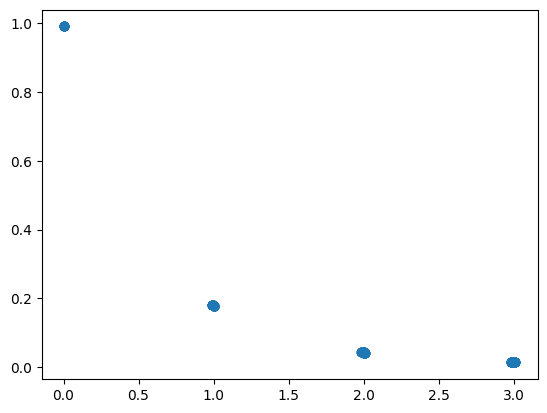

In [9]:
plt.plot(grad[:,3],S[37,:],'o')
#for i in range(0,nvox):
#    plt.plot(grad[:,3],S[i,:],'o')


In [10]:
#define the simple self-supervised neural network using function
from make_net import make_ss_net

model = "msdki"
#model = "ball"

Net = make_ss_net(tor_grad,model)

net = Net(tor_grad,model)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001) 


In [11]:
net

Net(
  (fc_layers): ModuleList(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): PReLU(num_parameters=1)
  )
  (encoder): Sequential(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=288, out_features=2, bias=True)
  )
)

In [12]:
#create batch queues 
batch_size = 128
num_batches = len(S) // batch_size
# X_train = X_train[:,1:] # exlude the b=0 value as signals are normalized
trainloader = utils.DataLoader(S,
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 2,
                                drop_last = True)

In [13]:
# Best loss
best = 1e16
num_bad_epochs = 0
patience = 5
total_epochs = 100

# Train
for epoch in range(total_epochs): 
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        X_pred, params_pred = net(X_batch)
        
        loss = criterion(X_pred, X_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      
    print("Loss: {}".format(running_loss))
    # early stopping
    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
print("Done")
# Restore best model
net.load_state_dict(final_model)


      
   
        
    


-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  8.12it/s]


Loss: 0.46082526072859764
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.69it/s]


Loss: 0.37751057744026184
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.42it/s]


Loss: 0.29782699421048164
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.88it/s]


Loss: 0.21934532187879086
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.88it/s]


Loss: 0.1436128467321396
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.48it/s]


Loss: 0.0717791230417788
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.84it/s]


Loss: 0.02636241214349866
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.56it/s]


Loss: 0.013888009707443416
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.71it/s]


Loss: 0.011214264668524265
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.45it/s]


Loss: 0.007988671364728361
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.84it/s]


Loss: 0.0058553575072437525
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.17it/s]


Loss: 0.0051916203810833395
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.23it/s]


Loss: 0.004706712381448597
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  8.71it/s]


Loss: 0.004272192280041054
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.89it/s]


Loss: 0.003961172653362155
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  8.10it/s]


Loss: 0.003687276446726173
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  8.65it/s]


Loss: 0.0034010072704404593
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.42it/s]


Loss: 0.003152313904138282
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.53it/s]


Loss: 0.002928735193563625
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00, 10.01it/s]


Loss: 0.0027098967402707785
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.54it/s]


Loss: 0.002512691280571744
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.84it/s]


Loss: 0.0023339914478128776
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.58it/s]


Loss: 0.0021711371082346886
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.77it/s]


Loss: 0.002014681842410937
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.97it/s]


Loss: 0.0018741574749583378
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.50it/s]


Loss: 0.0017455449706176296
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.77it/s]


Loss: 0.0016303499432979152
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.65it/s]


Loss: 0.0015202443464659154
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  8.89it/s]


Loss: 0.0014211621455615386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.38it/s]


Loss: 0.0013322974409675226
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.25it/s]


Loss: 0.001253200025530532
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.92it/s]


Loss: 0.001178755410364829
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.94it/s]


Loss: 0.0011116953537566587
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.63it/s]


Loss: 0.0010520367286517285
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00, 10.04it/s]


Loss: 0.0009995425934903324
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.75it/s]


Loss: 0.0009504029003437608
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00, 10.02it/s]


Loss: 0.0009094464330701157
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.87it/s]


Loss: 0.0008648726288811304
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00, 10.02it/s]


Loss: 0.0008265659780590795
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.93it/s]


Loss: 0.0007922302829683758
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.33it/s]


Loss: 0.0007607534062117338
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00, 10.13it/s]


Loss: 0.0007320789009099826
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.74it/s]


Loss: 0.000705822320014704
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.68it/s]


Loss: 0.0006804272416047752
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.59it/s]


Loss: 0.0006608868934563361
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.97it/s]


Loss: 0.0006384002845152281
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.71it/s]


Loss: 0.0006172308458189946
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00, 10.37it/s]


Loss: 0.0005979940033284947
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00, 10.11it/s]


Loss: 0.0005796396435471252
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.51it/s]


Loss: 0.0005636751448037103
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.84it/s]


Loss: 0.0005466284601425286
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.53it/s]


Loss: 0.0005321539392753039
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.90it/s]


Loss: 0.0005168782081454992
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.73it/s]


Loss: 0.000503711162309628
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.93it/s]


Loss: 0.0004902172513538972
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00, 10.31it/s]


Loss: 0.00047807394730625674
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.73it/s]


Loss: 0.0004661566490540281
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.99it/s]


Loss: 0.0004535859407042153
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.90it/s]


Loss: 0.00044185264778207056
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.73it/s]


Loss: 0.0004317069942771923
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.93it/s]


Loss: 0.0004206007615721319
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.68it/s]


Loss: 0.0004113589566259179
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.90it/s]


Loss: 0.0004009682197647635
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.80it/s]


Loss: 0.0003910167870344594
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00, 10.08it/s]


Loss: 0.00038203993244678713
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.82it/s]


Loss: 0.00037362840157584287
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00, 10.14it/s]


Loss: 0.00036492875005933456
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.94it/s]


Loss: 0.0003560562981874682
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.87it/s]


Loss: 0.00034847934512072243
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.93it/s]


Loss: 0.00034041433536913246
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00, 10.01it/s]


Loss: 0.00033326262200716883
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.59it/s]


Loss: 0.0003269023400207516
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.83it/s]


Loss: 0.0003194195305695757
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.94it/s]


Loss: 0.0003124877257505432
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.88it/s]


Loss: 0.0003063166095671477
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.68it/s]


Loss: 0.00030017343124200124
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.78it/s]


Loss: 0.0002953675611934159
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00, 10.22it/s]


Loss: 0.0002893662531278096
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.72it/s]


Loss: 0.00028419410955393687
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.66it/s]


Loss: 0.00027889874763786793
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.36it/s]


Loss: 0.0002742488868534565
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.41it/s]


Loss: 0.00026970623184752185
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.33it/s]


Loss: 0.0002634465872688452
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  8.93it/s]


Loss: 0.00025877250664052553
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.13it/s]


Loss: 0.0002534663162805373
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.24it/s]


Loss: 0.00024851744092302397
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  8.97it/s]


Loss: 0.0002444597557769157
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.22it/s]


Loss: 0.00024051238870015368
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.63it/s]


Loss: 0.0002363901203352725
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.48it/s]


Loss: 0.00023245693591888994
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00, 10.02it/s]


Loss: 0.00022946980425331276
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.20it/s]


Loss: 0.0002269139076815918
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  8.73it/s]


Loss: 0.00022218358208192512
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.76it/s]


Loss: 0.00021902140724705532
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.61it/s]


Loss: 0.00021577809638984036
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  8.90it/s]


Loss: 0.0002124379952874733
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.69it/s]


Loss: 0.00020964820942026563
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.92it/s]


Loss: 0.00020689330631284975
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.36it/s]


Loss: 0.0002045787732640747
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|██████████| 8/8 [00:00<00:00,  9.97it/s]

Loss: 0.00020189490169286728
############### Saving good model ###############################
Done


<All keys matched successfully>

In [14]:
#inference
net.eval()
with torch.no_grad():
    X_pred, params_pred = net(S)
    
X_pred = X_pred.numpy()
params_pred = params_pred.numpy()


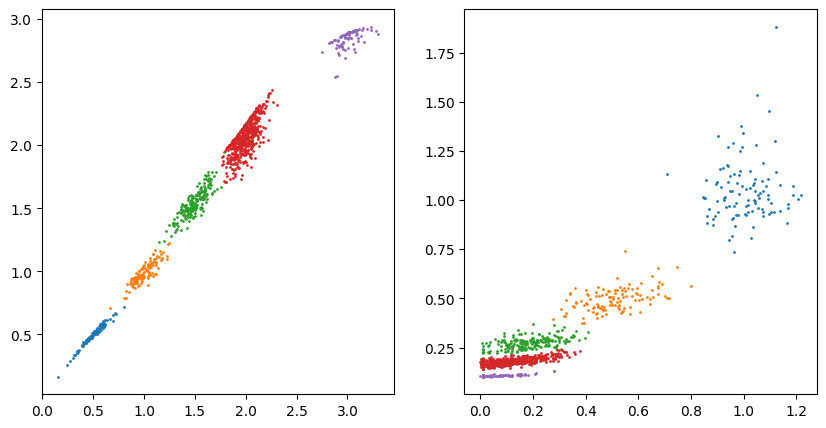

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

for i in range(0,nclus):
    ax[0].plot(params[clusters==i,0],params_pred[clusters==i,0],'o',markersize=1)

    ax[1].plot(params[clusters==i,1],params_pred[clusters==i,1],'o',markersize=1)


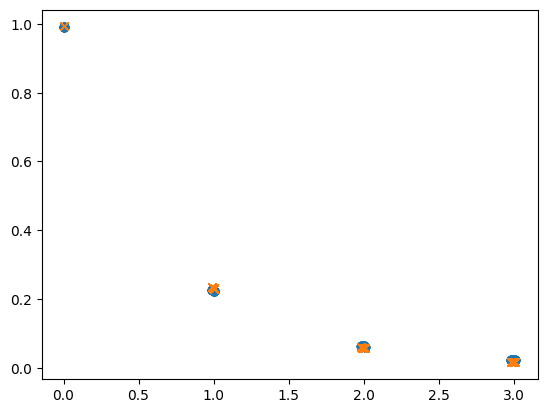

In [16]:
plt.plot(grad[:,3],X_pred[1,:],'o')
plt.plot(grad[:,3],S[1,:],'x')

In [17]:
dfssf

NameError: name 'dfssf' is not defined

In [ ]:
#jump straight in and define the neural network!

#WRITE A WRAPPER FUNCTION MAKEMODEL 
#makemodel(grad,modelname,latent_dim,network)
#different network VERSIONS - NORMAL NETWORK, VAE, ETC

class VariationalNet(nn.Module):
    def __init__(self, gradient_directions_no0, b_values_no0, nparams, latent_dim):
        super(VariationalNet, self).__init__()
        #add grad directions, bvals
        self.gradient_directions_no0 = gradient_directions_no0
        self.b_values_no0 = b_values_no0
        self.fc_layers = nn.ModuleList()
        
        self.mean = nn.Linear(latent_dim, latent_dim, bias=True)
        self.logvar = nn.Linear(latent_dim, latent_dim, bias=True)
        
        for i in range(3): # 3 fully connected hidden layers
            self.fc_layers.extend([nn.Linear(len(b_values_no0), len(b_values_no0)), nn.ReLU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values_no0), latent_dim))
        self.decoder = nn.Linear(latent_dim, nparams)
        #self.dropout = nn.Dropout(0.5)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, X):
        
        #X = self.dropout(X)
        
        
        output_latent = torch.abs(self.encoder(X)) 
        
        mu, logvar = self.mean(output_latent), self.logvar(output_latent)
        z = self.reparameterize(mu, logvar)
        params = self.decoder(z)
        params = F.softplus(params)

        D = torch.clamp(params[:, 0].unsqueeze(1), min = 0.01, max = 5)
        K = torch.clamp(params[:, 1].unsqueeze(1), min= 0.001, max=3)

        X = torch.exp(-self.b_values_no0*D + (self.b_values_no0**2 * D**2 * K / 6)) 
        
        return X, D, K, mu, logvar
    
    

In [ ]:
# Network
def kld_loss(mu, logvar, mu_prior=0.0, var_prior=1.0):
    # Kl between two Gaussians:
    #print(mu.size())
    #print(logvar.size())
    #loss = -0.5 - logvar.mean() + math.log(var_prior) + (logvar.mean().exp() + (mu.mean() - mu_prior)**2) / (2*(var_prior)**2)
    loss = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return loss, logvar.mean(), mu.mean()

nparams = 4
latent_dim = 128
b_values_no0 = torch.FloatTensor(grad[:,3])
gradient_directions_no0 = torch.FloatTensor(grad[:,0:2])
net = VariationalNet(gradient_directions_no0, b_values_no0, nparams, latent_dim)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001) 
#optimizer = optim.SGD(net.parameters(), lr = 0.01) 

In [ ]:
# Best loss
best = 1e16
num_bad_epochs = 0
patience = 5
total_epochs = 100
alpha = 1e-4

# Train
for epoch in range(total_epochs): 
    alpha_current = alpha * epoch / total_epochs
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.
    running_mse = 0.
    running_kl = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        X_pred, D_pred, K_pred, mu, logvar = net(X_batch)
        loss_kl, m, std = kld_loss(mu, logvar)
        loss_mse = criterion(X_pred, X_batch)
        loss = loss_mse + alpha_current*loss_kl.mean()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_mse += loss_mse.item()
        running_kl += loss_kl.item()
      
    print("Loss: {}, kl: {}, mse:{}, mu: {}, logvar:{}".format(running_loss / (i + 1), running_kl / (i+1), running_mse / (i+1), m, std))
    # early stopping
    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
print("Done")
# Restore best model
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


NameError: name 'net' is not defined

In [ ]:
tor_grad.size(0)

288